# ДЗ 1, часть 3. ЕМ-алгоритм

Имя, Фамилия: Игнат Сальников

группа: 221

**Оценка(для проверяющего):** 0 из 10

**Дедлайн:** 5 ноября 23:59 (решение нужно сдать в энитаск)

In [26]:
#all imports here please
import pickle as pkl
import tqdm
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
#... add your own if necessary

## Задача 1. Поломки (5 баллов)

В офисе одного небольшого СобериБанка происходят поломки серверной. Служба обслуживания в таких случаях посылает специалиста решить проблему.  Для этого необходимо произвести обслуживание вычислительного узла А и вычислительного узла B. Каждый специалист имеет какую-то свою инструкцию, методологию, а также свой опыт, который определяет то, как именно он занимается ремонтном, и то, сколько времени у него занимают ремонтные работы.

В офисе точно могут сказать, сколько суммарно времени занял ремонт каждого из узлов(в минутах), обозначим их за переменные $X_A,~X_B$, но очень сложно понять, какие конкретно рабочие занимались ремонтом в каждом случае.

Коллеги вас, как экперта в статистике, просят оценить, сколько рабочих занято в ремонте вашей серверной. Немного посидев в браузере, вы узнаёте, что, оказывается, времена обслуживания техники можно моделировать с помощью знакомого [логнормального распределения](https://en.wikipedia.org/wiki/Log-normal_distribution). 

Используя ЕМ-алгоритм, модель смеси распределений, а также приложенный датасет, определите сколько рабочих могло участвовать в ремонте серверной за время наблюдений. Можете ли вы определить, какой рабочий участвовал в каждом ремонте?

Действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте диаграмму разброса (scatterplot) в осях $X_A,~X_B$, чтобы посмотреть, что в целом дано. Возможно, удобнее перейти в логарифмические оси.

In [3]:
with open("./maintenance.pkl","rb") as f:
    dd = pkl.load(f)

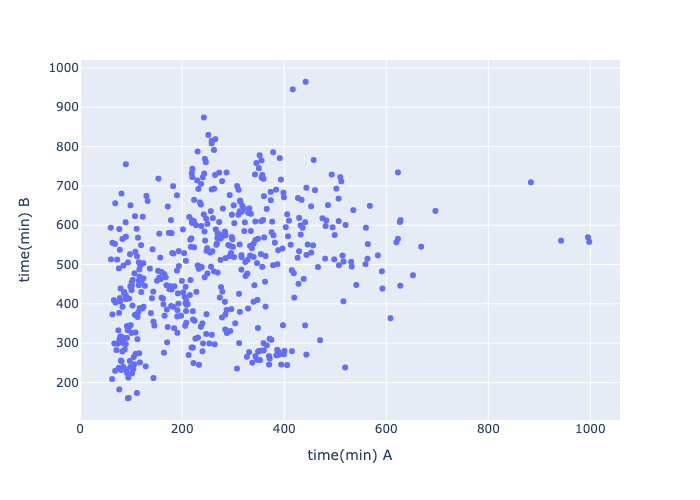

In [4]:
df = pd.DataFrame(
    {"time(min) A" : dd['times(min)'][:, 0],
     "time(min) B" : dd['times(min)'][:, 1],
     'component' : ['?' for _ in range(dd['times(min)'].shape[0])]
    }
)

fig = px.scatter(df, x='time(min) A', y='time(min) B')
fig.show(renderer='png')

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. Число компонент будем определять экспериментально, а остальное надо оценивать. Предполагается, что вектор $[\ln X_A, \ln X_B]$ у каждого рабочего имеет нормальное распределение. Логарифмы $\ln X_A$ и $\ln X_B$ могут быть коррелированы, но пары  $(X^i_A,X^i_B)$ независимы в совокупности.

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i_A, X^i_B)$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

* $Y_i$ номер рабочего, который чинил $A_i$ и $B_i$
* Вектор логарифмов имеет многомерное нормальное распределение, значит просто вектор должен иметь многомерное логнормальное.
* Количество рабочих $K$ - определим извне EM алгоритма и параметры $\pi_1, \dots, \pi_K$ для мультиномиального распределения для одного эксперемента (вероятности выбора компонент)

Решение для фиксированного количества рабочих $K = k$ и потом берем тот $K = k^\star$, который максимизирует логарифм  правдоподобия (вообще подходят все $k \geq k^\star$, так как в смеси могут быть одинаковые компоненты, мы возьмем наимньший из них). В целом сильно проще прологарифмировать $X, Y$ и работать с многомерным нормальным распределением, так я и сделаю.

### Матчасть (нотацию и часть решения возьму с семинаров по МОПу)

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).


\begin{equation*}
 	p(Z | X,\Theta^{\text{old}}) = \frac{p(X, Z | \Theta^{\text{old}})}{p(X | \Theta^{\text{old}})} = \frac{\prod_{i = 1}^{\ell}\prod_{k = 1}^{K} \Bigl[\pi_k^{\text{old}} \text{pdf}(x_i | \mu_k^{\text{old}}, \Sigma_k^{\text{old}}) \Bigr]^{z_{ik}}}{\sum_Z \prod_{i = 1}^{\ell}\prod_{k = 1}^{K} \Bigl[\pi_k^{\text{old}} \text{pdf}(x_i | \mu_k^{\text{old}}, \Sigma_k^{\text{old}}) \Bigr]^{z_{ik}}}
 \end{equation*}



Заметим, что данное распределение факторизуется в произведение распределений, соответствующих отдельным объектам~$p(z_i | x_i, \Theta^{\text{old}})$:
\begin{equation*}
p(Z | X, \Theta^{\text{old}}) = \prod_{i = 1}^{\ell}p(z_i | x_i, \Theta^{\text{old}}) = \prod_{i = 1}^{\ell} \frac{\prod_{k = 1}^{K} \Bigl[\pi_k^{\text{old}} \text{pdf}(x_i | \mu_k^{\text{old}}, \Sigma_k^{\text{old}}) \Bigr]^{z_{ik}}}{\sum_{k=1}^K \pi_k^{\text{old}} \text{pdf}(x_i | \mu_k^{\text{old}}, \Sigma_k^{\text{old}})}
\end{equation*}

Введём обозначение:

\begin{align*}
g_{ik} \equiv p(z_{ik} = 1 | x_i, \Theta^{\text{old}}) = \frac{\pi_k^{\text{old}} \text{pdf}(x_i | \mu_k^{\text{old}}, \Sigma_k^{\text{old}})}{\sum_{s = 1}^{K}\pi_s^{\text{old}} \text{pdf}(x_i | \mu_s^{\text{old}}, \Sigma_s^{\text{old}})}.
\end{align*}

Вычислим теперь матожидание полного правдоподобия:
\begin{align*}
	Q = \mathbb{E}_{Z \sim p(Z | X, \Theta^{\text{old}})} \log p(X, Z | \Theta) = 
\sum_{i = 1}^{\ell} \sum_{k = 1}^{K}
    \mathbb{E}_{Z \sim p(Z | X, \Theta^{\text{old}})}
        [z_{ik}]
    \Bigl\{
        \log \pi_k
        +
        \log \text{pdf}(x_i | \mu_k, \Sigma_k)
    \Bigr\}.
\end{align*}


Нам понадобится вспомогательная величина:
\begin{align*}
\mathbb{E}_{Z \sim p(Z | X, \Theta^{\text{old}})}[z_{ik}] &= 1 * p(z_{ik} = 1 | x_i, \Theta^{\text{old}}) + 0 * p(z_{ik} = 0 | x_i, \Theta^{\text{old}}) = g_{ik}.
\end{align*}
Получаем следующую оптимизационную задачу:
$$
\mathbb{E}_{Z \sim p(Z | X, \Theta^{\text{old}})} \log p(X, Z | \Theta)   =
\sum_{i = 1}^{\ell}
\sum_{k = 1}^{K}
    g_{ik}
    \Bigl\{
        \log \pi_k
        +
        \log \text{pdf}(x_i | \mu_k, \Sigma_k)
    \Bigr\} \to \max_{\{\pi_k, \mu_k, \Sigma_k\}}
$$



На параметры $\pi_k$ есть ограничение $\sum_k \pi_k = 1$, поэтому воспользуемся методом множиетелей Лагранжа:
    \begin{equation*}
        \mathcal{F}(\pi, \lambda) = \sum_{i = 1}^{\ell} \sum_{k = 1}^{K} g_{ik} \log \pi_k + \lambda \left(\sum_{k=1}^K \pi_k - 1\right)
    \end{equation*}
    \begin{equation*}
        \nabla_{\pi_k} \mathcal{F} = \sum_i g_{ik} \dfrac{1}{\pi_k} + \lambda \Rightarrow \pi_k = \dfrac{1}{\lambda} \sum_i g_{ik}, ~~~ \lambda = \ell
    \end{equation*}
    \begin{equation*}
        \pi_k = \dfrac{1}{\ell} \sum_i g_{ik}
    \end{equation*}
    


\begin{equation*}
        \mathcal{L}(q^*, \Theta) \propto_{\mu_k} \sum_{i = 1}^{\ell} \sum_{k = 1}^{K} g_{ik} \left[ -\dfrac{1}{2}(\log{x_i} - \mu_k)^T \Sigma^{-1}_k (\log{x_i} - \mu_k) \right]
\end{equation*}
    
\begin{equation*}
        \nabla_{\mu_k} \mathcal{L} = \Sigma_k^{-1} \sum_{i = 1}^{\ell} g_{ik} (\log{x_i} - \mu_k) = 0 \Rightarrow \sum_{i = 1}^{\ell} g_{ik} \log{x_i} = \mu_k \sum_{i = 1}^{\ell} g_{ik}
\end{equation*}
    
\begin{equation*}
        \mu_k = \dfrac{1}{\ell \pi_k} \sum_{i = 1}^{\ell} g_{ik} \log{x_i}
\end{equation*}
    
Обозначим $\Lambda_k = \Sigma_k^{-1}$, тогда:
    
\begin{equation*}
    \mathcal{L}(q^*, \Theta) \propto_{\Lambda_k} \sum_{i = 1}^{\ell} \sum_{k = 1}^{K} g_{ik} \left[ -\dfrac{1}{2}(\log{x_i}  - \mu_k)^T \Lambda_k (\log{x_i}  - \mu_k) + \dfrac{1}{2} \log \text{det} \Lambda_k \right]
\end{equation*}

\begin{equation*}
        \nabla_{\Lambda_k} \mathcal{L} = \sum_{i = 1}^{\ell} g_{ik} \left[- \dfrac{1}{2} (\log{x_i}  - \mu_k) (\log{x_i}  - \mu_k)^T + \dfrac{1}{2} \Lambda^{-1} \right] = 0
\end{equation*}
    
\begin{equation*}
        \Sigma_k = \Lambda^{-1}_k = \dfrac{1}{\ell \pi_k} \sum_{i = 1}^{\ell} g_{ik} (\log{x_i}  - \mu_k) (\log{x_i}  - \mu_k)^T
\end{equation*}

<span style="color:red">**ВАЖНО**</span>

Как видим параметры нормального распределения для $[\ln X_A, \ln X_B]$ совпадают с параметрами логнормального для $[X_A, X_B]$, а значит наши оценки параметров через EM алгоритм для нормального распределения будут совпадать с оценками через EM алгоритм для логнормального распределения.

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

<span style="color:red">**Я написал EM алгоритм для нормального.**</span>


Будем просто брать логарифм перед fit(), и экспоненту после sample() чтобы получить логнормальное.

In [5]:
from scipy.stats import multinomial
from scipy.stats import multivariate_normal


class LogNMixtureModel:
    '''
    Implements NN Mixture Model in R^d
    '''

    def __init__(self,K=1,mus=[0],sigmas=[1], pis=[1], allow_singular=False):
        """
        Args:
            K (int, optional): number of components. Defaults to 1.
            mus (list, optional): K entries of (d,), expected values. Defaults to [0].
            sigmas (list, optional): K entries of (d,d,), covariances. Defaults to [1].
            pis (list, optional): K floats, weights, positive and sump up to 1. Defaults to [1].
        """        
        self.K=K
        self.mus = mus
        self.sigmas = sigmas
        self.pis = pis
        self.allow_singular = allow_singular
        
        self.Q = None
        self.loglike = None

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print as if you would write print(myModel)
        """ 
        
        s = f"K = {self.K},   Q = {self.Q},   loglike = {self.loglike}\n\n"
        
        for i in range(self.K):
            s += f"mus_{i} = {self.mus[i]},\n  sigmas_{i} = {self.sigmas[i]},\n  pis_{i} = {self.pis[i]}\n\n"
            
        return s

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """        
        
        
        draw = np.argmax(multinomial.rvs(1, self.pis, size=N), axis=1)
                
        observation = np.array([
            multivariate_normal.rvs(mean=self.mus[ca], cov=self.sigmas[ca]) 
            for ca in draw
        ])
        
        return observation, draw


    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """       
        
        logits = self._pdf(data)
        
        self.gammas = logits / logits.sum(axis=1, keepdims=True)
        
    
    def Mstep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """        

        pis = self.gammas.sum(axis=0) 
        
        self.pis = pis / self.N
                        
        self.mus = np.array([
            np.sum(self.gammas[:, k, None] * data, axis=0) / pis[k] 
                for k in range(self.mus.shape[0])
        ])

        for k in range(self.sigmas.shape[0]):
        
            sigma = np.zeros_like(self.sigmas[k])
            
            for i in range(self.N):
                vec = data[i] - self.mus[k]

                sigma += self.gammas[i, k] * np.outer(vec, vec)
                
            self.sigmas[k] = 1 / pis[k] * sigma
            
    def _fit(self, data, nSteps, K):
        self.K = K
            
        self.mus = np.random.uniform(low=0.2, high=0.8, size=(self.K, 2))
        
        self.sigmas = np.array([
            np.diag(np.random.uniform(low=0.2, high=0.8, size=2)) 
                for _ in range(self.K)
        ])

        b = np.random.uniform(low=0.2, high=0.8, size=(self.K))
        self.pis = b / np.sum(b)

        for _ in tqdm.tqdm(np.arange(nSteps)):
            self.EStep(data)
            self.Mstep(data)               
            
    def fit(self, data, nSteps, K):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """        
        
        self.N = len(data)
        data = np.array(data)
                
        self._fit(data, nSteps, K)
        
        self.Q = self._Qfun(data)
        self.loglike = self._loglike(data)
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        
        Q = (self.gammas * (self.pis + np.log(self._pdf(data).clip(10e-10, None)))).sum()
                
        return Q
    
    def _pdf(self, data):
        for k in range(len(self.sigmas)):
            if np.linalg.det(self.sigmas[k]) < 10e-12:
                self.sigmas[k] += 10e-12 * np.diag(np.diag(np.ones_like(self.sigmas[k])))
                        
        logits = np.array([
            multivariate_normal.pdf(data, mean=mu_, cov=sigm_, allow_singular=self.allow_singular) * pi_
                for mu_, sigm_, pi_ in zip(self.mus, self.sigmas, self.pis)
        ]).T
        
        return logits
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
             
        return np.log(self._pdf(data).sum())    

<span style="color:red">**ВНИМАНИЕ**</span>

Мой алгоритм работает с нормально распределенными СВ, их нужно преобразовывать. В этих примерах я этого делать **не** буду - получается что шкала на всех графиках логарифмическая.

In [6]:
#Test1: init model and sample from it, draw scatter plot

mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(100)

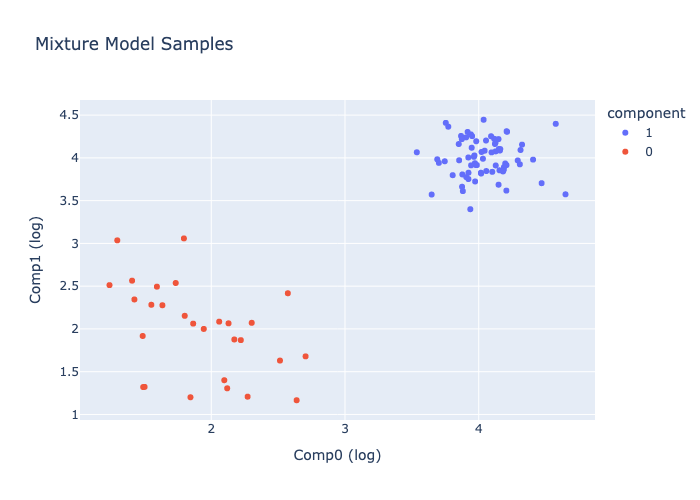

In [7]:
df1 = pd.DataFrame({"Comp0 (log)" : xs[:, 0], "Comp1 (log)" : xs[:, 1], 'component' : ids.astype(str)})

fig = px.scatter(df1, x='Comp0 (log)', y='Comp1 (log)', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

In [8]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
mus = [np.array([2,2]), np.array([3,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2), 0.05*np.eye(2)]
pis=[0.3 ,0.2, 0.5]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(2000)

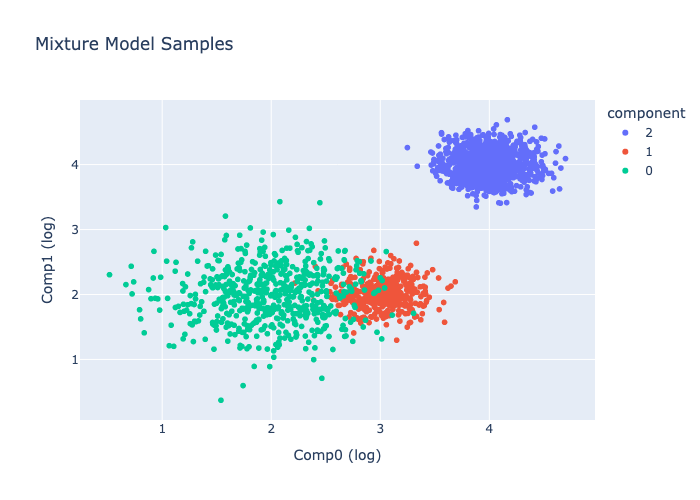

In [9]:
df1 = pd.DataFrame({"Comp0 (log)" : xs[:, 0], "Comp1 (log)" : xs[:, 1], 'component' : ids.astype(str)})

fig = px.scatter(df1, x='Comp0 (log)', y='Comp1 (log)', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

In [10]:
mixMod.fit(xs, 100, 3)
print(mixMod)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.84it/s]

K = 3,   Q = -1848.1413434377005,   loglike = 6.913218065389294

mus_0 = [2.02546703 1.99408229],
  sigmas_0 = [[0.24389069 0.00858553]
 [0.00858553 0.18282387]],
  pis_0 = 0.3127323727407295

mus_1 = [3.02039929 2.00998812],
  sigmas_1 = [[0.05057883 0.00088797]
 [0.00088797 0.04748187]],
  pis_1 = 0.1887678102086213

mus_2 = [4.0076584  4.01237184],
  sigmas_2 = [[ 0.05041537 -0.00051233]
 [-0.00051233  0.0480552 ]],
  pis_2 = 0.4984998170506492




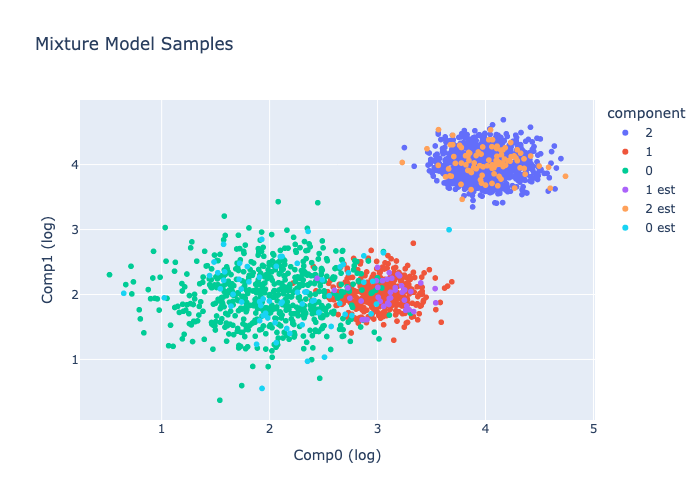

In [11]:
xs_, ids_ = mixMod.sample(200)

df2 = pd.DataFrame({"Comp0 (log)" : xs_[:, 0], "Comp1 (log)" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
df3 =  pd.concat([df1, df2], axis=0)

fig = px.scatter(df3, x='Comp0 (log)', y='Comp1 (log)', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

In [12]:
mus = [np.zeros([2]), np.zeros([2])]
sigmas = [np.eye(2), np.eye(2)]
pis=[0.9,0.1]

mixMod1 = LogNMixtureModel(2,mus,sigmas,pis)
xs, ids = mixMod1.sample(1000)

In [13]:
mixMod1.fit(xs, 100, 1)
print(mixMod1)

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 467.70it/s]

K = 1,   Q = -1829.705069224065,   loglike = 4.391713385159303

mus_0 = [ 0.00810042 -0.0417779 ],
  sigmas_0 = [[ 0.9639315  -0.03121356]
 [-0.03121356  1.02161111]],
  pis_0 = 1.0




In [14]:
# как видим если взять k >= 1 то правдоподобие не меняется, а вот качество модели становится существенно хуже

mixMod1.fit(xs, 100, 2)
print(mixMod1)

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 235.98it/s]

K = 2,   Q = -2933.4432903059765,   loglike = 4.396916354644591

mus_0 = [ 0.2966632  -0.29905836],
  sigmas_0 = [[ 0.85735702 -0.04498867]
 [-0.04498867  0.7497029 ]],
  pis_0 = 0.4810719606941801

mus_1 = [-0.25941155  0.19673381],
  sigmas_1 = [[0.91397466 0.11418698]
 [0.11418698 1.15543124]],
  pis_1 = 0.5189280393058199




<span style="color:red">**ИНТЕРЕСНО**</span>

Тут важно заметить что при $k  = 1$ у нас просто детерминированный алгоритм (по идее это MLE, но я сильно долго об этом не умал).

In [15]:
np.mean(xs, axis=0)

array([ 0.00810042, -0.0417779 ])

In [16]:
np.cov(xs, rowvar=False)

array([[ 0.96489639, -0.03124481],
       [-0.03124481,  1.02263375]])

Параметры должны быть примерно как настоящие, это очень простой случай для EM.

### Переходим к данным

Для оценки количества рабочих можно путём эксперимента подобрать количество кластеров. Попробуйте разное количество кластеров и подберите лучший. Ответьте на вопрос задачи и обоснуйте ваш выбор, используя написанный вами код.

Я буду подбирать такое минимаьное k, которое бы максимизировало правдоподобие. При этом из-за численной нестабтльности прогоню каждое по несколько раз для того чтобы алгоритм мог 'сойтись' к наиболее вероятному распределению.

<span style="color:red">**ВНИМАНИЕ**</span>

Я снова не буду брать экспоненту от нормального чтобы получить логнормальное - получется что относительно исходного распределения оси логарифмические.

In [17]:
# приводим распределение к нормальному

df['Comp0'] = np.log(df['time(min) A'])
df['Comp1'] = np.log(df['time(min) B'])

mixMod = LogNMixtureModel()

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 943.58it/s]


K = 1,   Q = -96.49437742386263,   loglike = 5.230626756425589

mus_0 = [5.44167508 6.13842067],
  sigmas_0 = [[0.36843849 0.0725345 ]
 [0.0725345  0.1174908 ]],
  pis_0 = 1.0




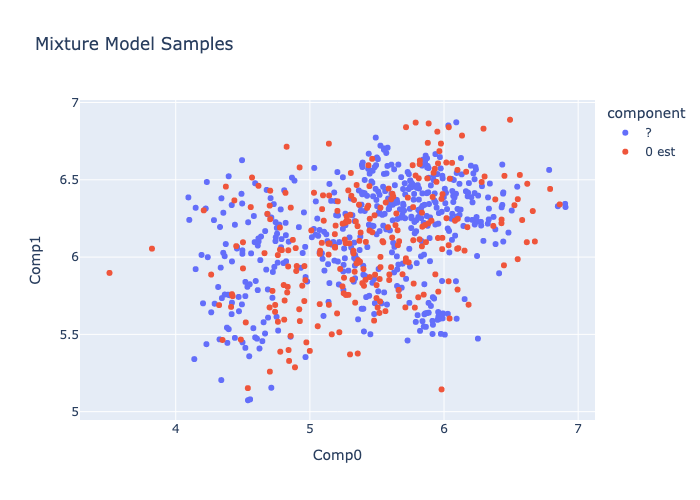

In [18]:
np.random.seed(0)

mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 1)
print(mixMod)

xs_, ids_ = mixMod.sample(256)

df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
df3 =  pd.concat([df, df2], axis=0)

fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 493.44it/s]

K = 2,   Q = -235.96334151298845,   loglike = 5.334468512908419

mus_0 = [4.52787675 5.90595993],
  sigmas_0 = [[0.04153629 0.00182962]
 [0.00182962 0.12558471]],
  pis_0 = 0.21721321935985896

mus_1 = [5.69524231 6.20292553],
  sigmas_1 = [[0.16314398 0.01685344]
 [0.01685344 0.09608912]],
  pis_1 = 0.7827867806401411




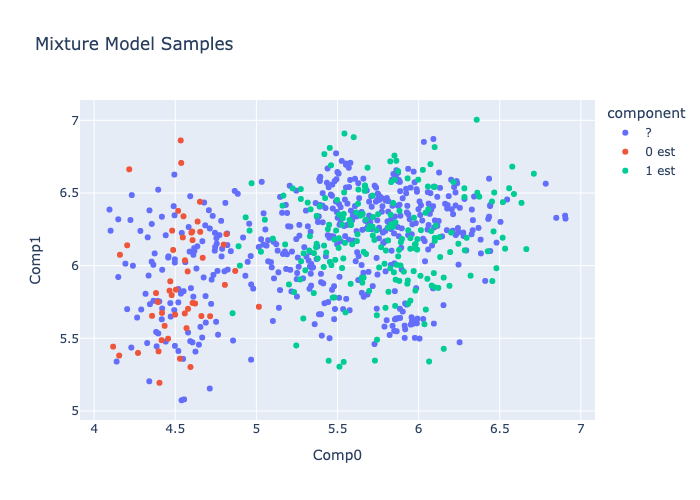

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.38it/s]

K = 2,   Q = -72.82803159248272,   loglike = 9.983063850304418

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.00421052494219718

mus_1 = [5.44545992 6.14290988],
  sigmas_1 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_1 = 0.9957894750578029




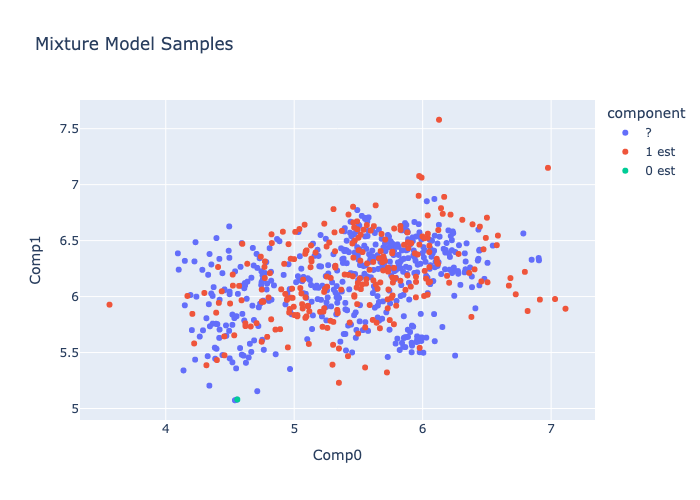

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 463.03it/s]

K = 2,   Q = -103.43428914361559,   loglike = 5.383149778278724

mus_0 = [5.91699522 5.60475409],
  sigmas_0 = [[0.00530087 0.00015288]
 [0.00015288 0.00360936]],
  pis_0 = 0.058361767691037174

mus_1 = [5.41221522 6.17149678],
  sigmas_1 = [[0.37607464 0.09371679]
 [0.09371679 0.10580341]],
  pis_1 = 0.9416382323089629




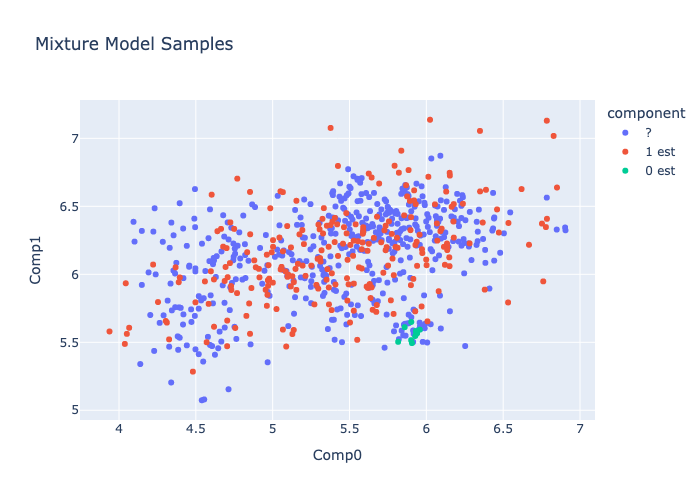

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.23it/s]

K = 2,   Q = -72.8280315924827,   loglike = 9.983063850304418

mus_0 = [5.44545992 6.14290988],
  sigmas_0 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_0 = 0.9957894750578029

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.00421052494219718




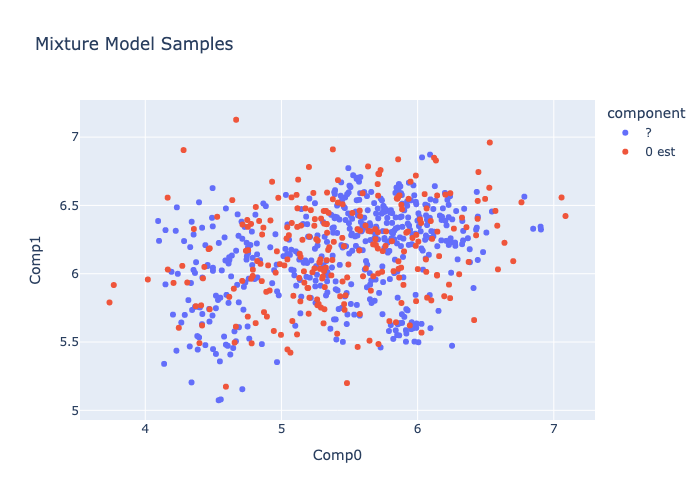

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 482.48it/s]

K = 2,   Q = -72.8280315924827,   loglike = 9.983063850304418

mus_0 = [5.44545992 6.14290988],
  sigmas_0 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_0 = 0.9957894750578029

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.00421052494219718




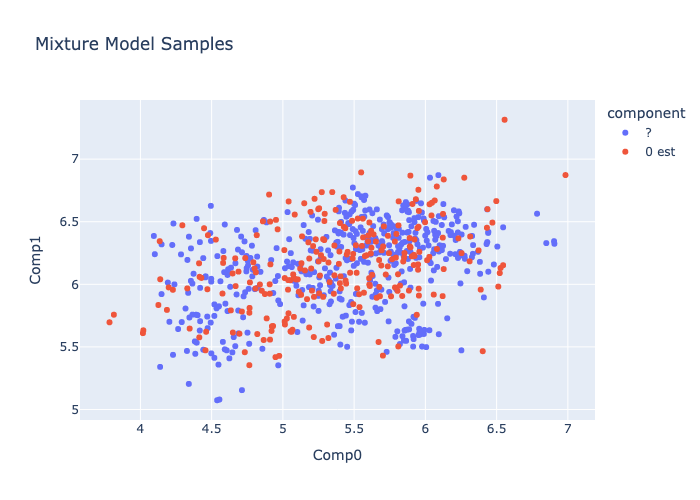

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 487.13it/s]

K = 2,   Q = -235.9633416169136,   loglike = 5.334468512953852

mus_0 = [4.52787675 5.90595993],
  sigmas_0 = [[0.04153629 0.00182962]
 [0.00182962 0.12558471]],
  pis_0 = 0.21721321961343523

mus_1 = [5.69524231 6.20292553],
  sigmas_1 = [[0.16314398 0.01685344]
 [0.01685344 0.09608912]],
  pis_1 = 0.7827867803865648




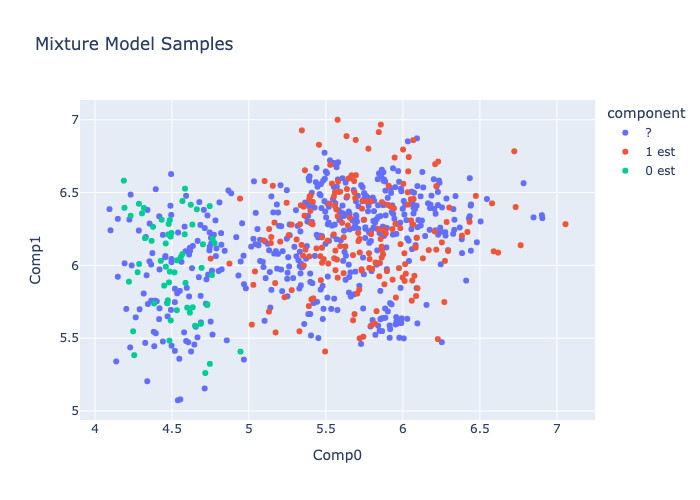

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 495.49it/s]

K = 2,   Q = -235.9633416113735,   loglike = 5.33446851295143

mus_0 = [4.52787675 5.90595993],
  sigmas_0 = [[0.04153629 0.00182962]
 [0.00182962 0.12558471]],
  pis_0 = 0.2172132195999174

mus_1 = [5.69524231 6.20292553],
  sigmas_1 = [[0.16314398 0.01685344]
 [0.01685344 0.09608912]],
  pis_1 = 0.7827867804000826




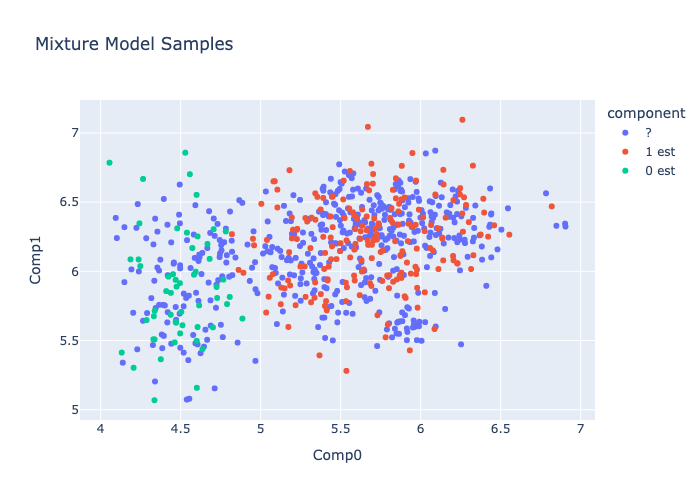

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 485.64it/s]

K = 2,   Q = -72.8280315924827,   loglike = 9.983063850304418

mus_0 = [5.44545992 6.14290988],
  sigmas_0 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_0 = 0.9957894750578029

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.00421052494219718




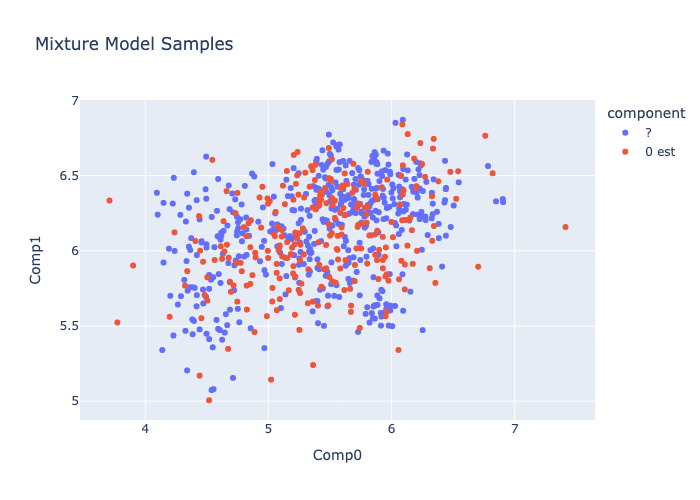

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 460.88it/s]

K = 2,   Q = -72.82803159248272,   loglike = 9.983063850304418

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.00421052494219718

mus_1 = [5.44545992 6.14290988],
  sigmas_1 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_1 = 0.9957894750578029




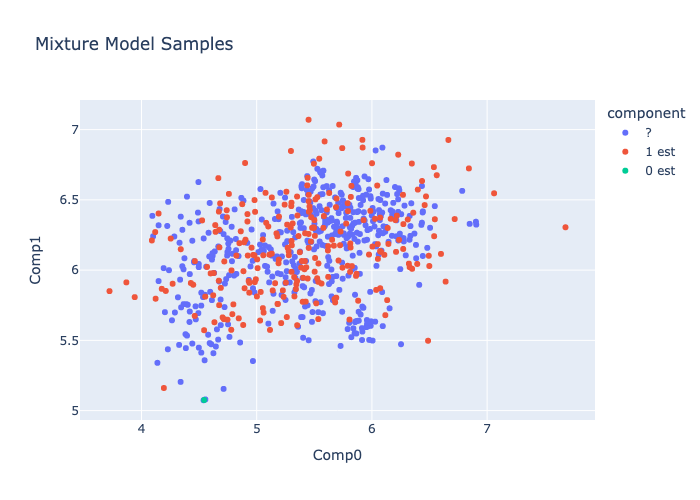

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.96it/s]

K = 2,   Q = -72.82803159248272,   loglike = 9.983063850304418

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.00421052494219718

mus_1 = [5.44545992 6.14290988],
  sigmas_1 = [[0.3665939  0.06880574]
 [0.06880574 0.11320121]],
  pis_1 = 0.9957894750578029




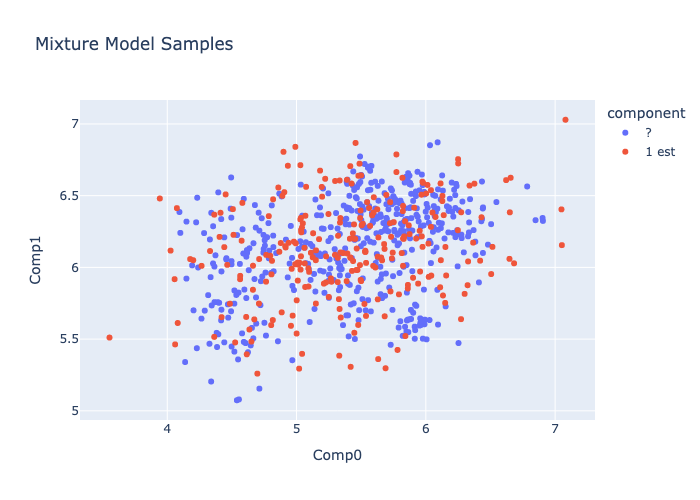

In [19]:
for sd in range(10):
    np.random.seed(sd)
    
    mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 2)
    print(mixMod)

    xs_, ids_ = mixMod.sample(256)

    df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
    df3 =  pd.concat([df, df2], axis=0)

    fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
    fig.show(renderer='png')

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.66it/s]

K = 3,   Q = -376.83311867284647,   loglike = 5.540568531503496

mus_0 = [5.08819494 6.00953299],
  sigmas_0 = [[0.31136579 0.04169111]
 [0.04169111 0.10344872]],
  pis_0 = 0.5485760682987095

mus_1 = [5.91783887 5.6065246 ],
  sigmas_1 = [[ 5.03497906e-03 -1.46734285e-05]
 [-1.46734285e-05  3.56256876e-03]],
  pis_1 = 0.05751149730134515

mus_2 = [5.86442348 6.39557132],
  sigmas_2 = [[ 0.11515064 -0.00909955]
 [-0.00909955  0.02311337]],
  pis_2 = 0.39391243439994533




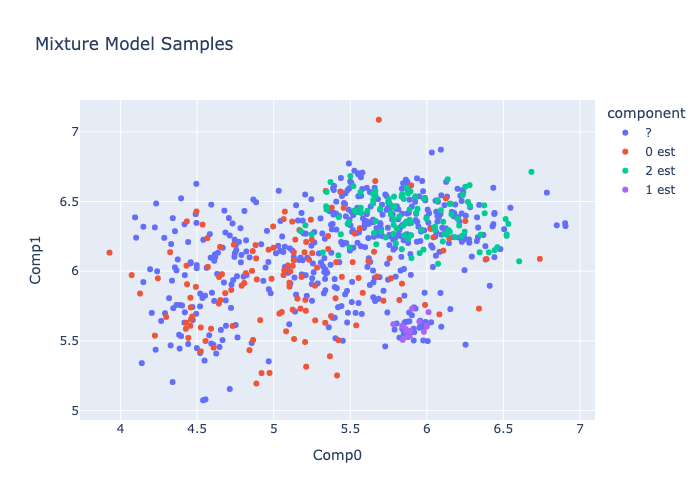

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.92it/s]

K = 3,   Q = -213.66352033277232,   loglike = 9.98395865968209

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.004210520669515036

mus_1 = [4.53096485 5.92520855],
  sigmas_1 = [[0.04331961 0.00302032]
 [0.00302032 0.11374118]],
  pis_1 = 0.21534021336401604

mus_2 = [5.69778582 6.20297765],
  sigmas_2 = [[0.16137203 0.0168688 ]
 [0.0168688  0.09636726]],
  pis_2 = 0.780449265966469




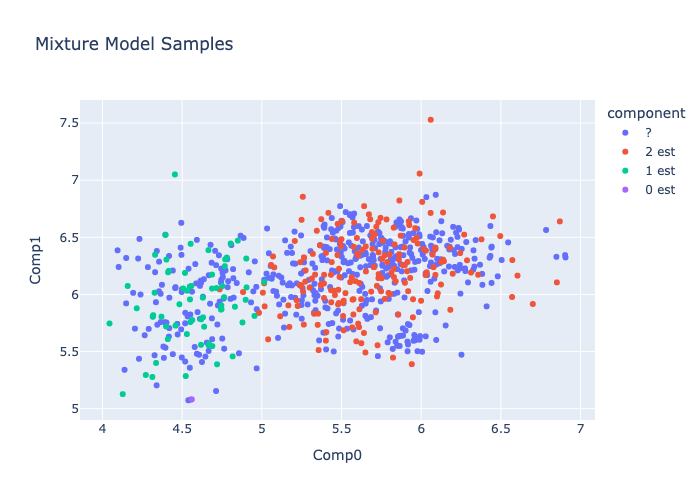

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.59it/s]

K = 3,   Q = -213.66352029476639,   loglike = 9.983958659629495

mus_0 = [4.53096485 5.92520855],
  sigmas_0 = [[0.04331961 0.00302032]
 [0.00302032 0.11374118]],
  pis_0 = 0.21534021327774922

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.004210520669515032

mus_2 = [5.69778582 6.20297765],
  sigmas_2 = [[0.16137203 0.0168688 ]
 [0.0168688  0.09636726]],
  pis_2 = 0.7804492660527358




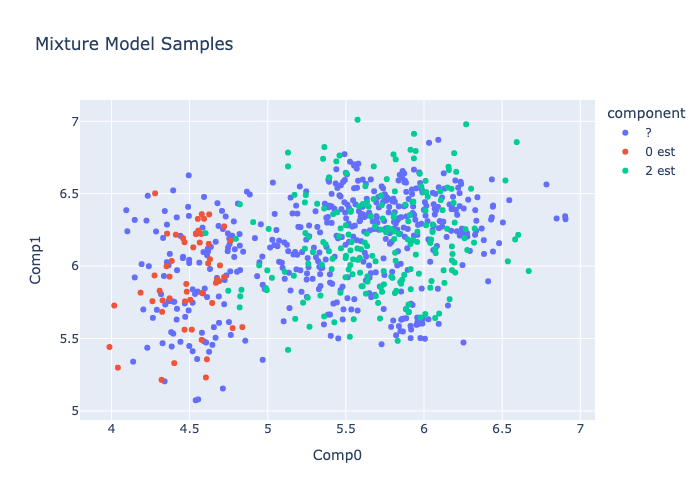

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.11it/s]

K = 3,   Q = -229.02514253392366,   loglike = 5.483752721908345

mus_0 = [5.91443891 5.60323934],
  sigmas_0 = [[0.00604907 0.00065057]
 [0.00065057 0.00397966]],
  pis_0 = 0.060581054155659946

mus_1 = [4.5137403  5.88853723],
  sigmas_1 = [[ 0.03905725 -0.00272462]
 [-0.00272462  0.12874677]],
  pis_1 = 0.20361531580469694

mus_2 = [5.65953375 6.25163287],
  sigmas_2 = [[0.18528117 0.03128046]
 [0.03128046 0.07004373]],
  pis_2 = 0.7358036300396431




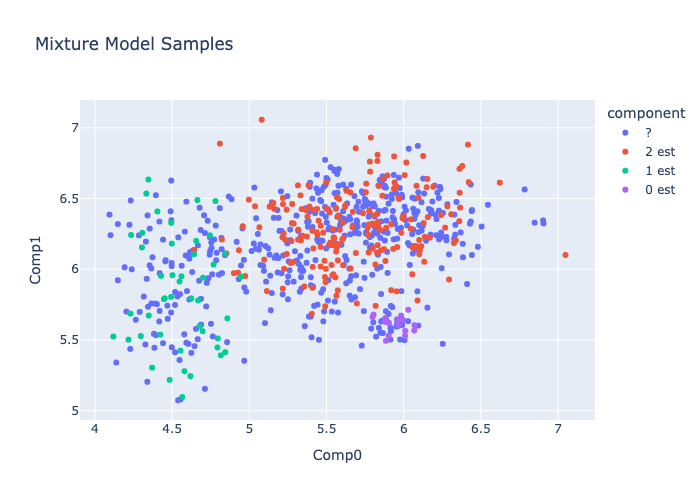

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.41it/s]

K = 3,   Q = -82.99833319364726,   loglike = 16.634110007663633

mus_0 = [6.252704   5.47256646],
  sigmas_0 = [[2.e-11 0.e+00]
 [0.e+00 2.e-11]],
  pis_0 = 0.0021052631577785723

mus_1 = [5.41006533 6.17338791],
  sigmas_1 = [[0.37541312 0.09544726]
 [0.09544726 0.10481268]],
  pis_1 = 0.9389942745103091

mus_2 = [5.91661095 5.60477053],
  sigmas_2 = [[0.00541417 0.0002231 ]
 [0.0002231  0.0036835 ]],
  pis_2 = 0.05890046233191224




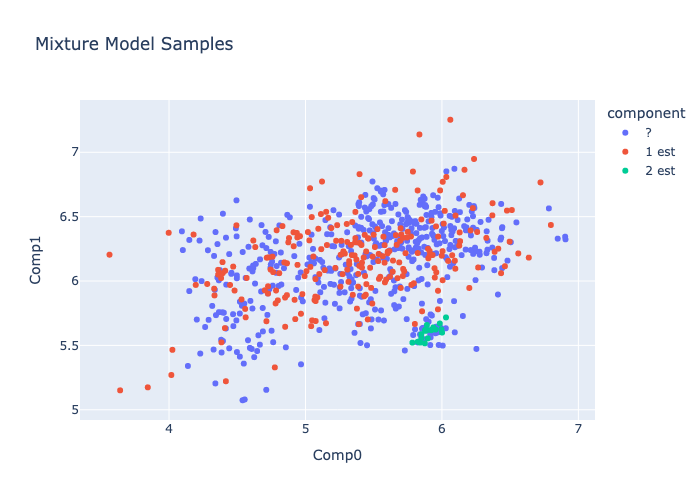

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.89it/s]

K = 3,   Q = -76.54669197262884,   loglike = 9.983156633563313

mus_0 = [5.45710148 6.14148291],
  sigmas_0 = [[0.35547986 0.07128515]
 [0.07128515 0.1140091 ]],
  pis_0 = 0.9864832815889613

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.004210524859754422

mus_2 = [4.21142123 6.29417312],
  sigmas_2 = [[ 0.00749652 -0.0055938 ]
 [-0.0055938   0.00446598]],
  pis_2 = 0.009306193551284323




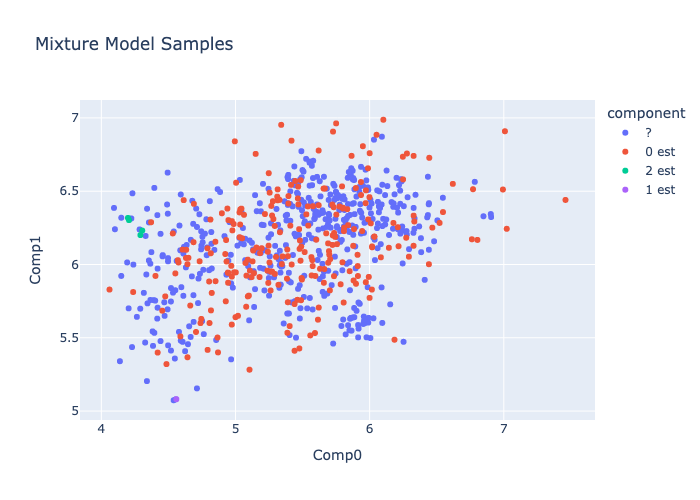

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.70it/s]

K = 3,   Q = -229.02514558059846,   loglike = 5.483752723958276

mus_0 = [5.91443891 5.60323934],
  sigmas_0 = [[0.00604907 0.00065057]
 [0.00065057 0.00397966]],
  pis_0 = 0.060581053968212145

mus_1 = [4.51374031 5.88853724],
  sigmas_1 = [[ 0.03905726 -0.00272462]
 [-0.00272462  0.12874677]],
  pis_1 = 0.2036153246267694

mus_2 = [5.65953376 6.25163287],
  sigmas_2 = [[0.18528116 0.03128046]
 [0.03128046 0.07004373]],
  pis_2 = 0.7358036214050184




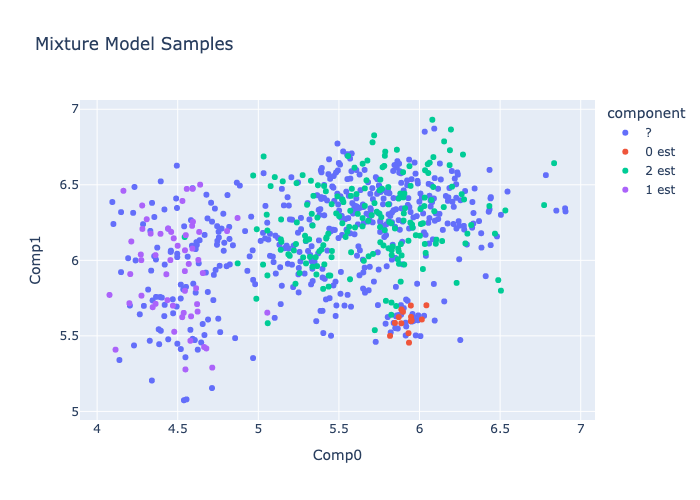

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.77it/s]

K = 3,   Q = -73.30868071818618,   loglike = 9.983511260378235

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.004210525309276411

mus_1 = [4.3861341  5.53697112],
  sigmas_1 = [[ 0.01144709 -0.01021175]
 [-0.01021175  0.00915141]],
  pis_1 = 0.013924862455059755

mus_2 = [5.46048335 6.15150334],
  sigmas_2 = [[0.35549021 0.06069399]
 [0.06069399 0.10939589]],
  pis_2 = 0.9818646122356638




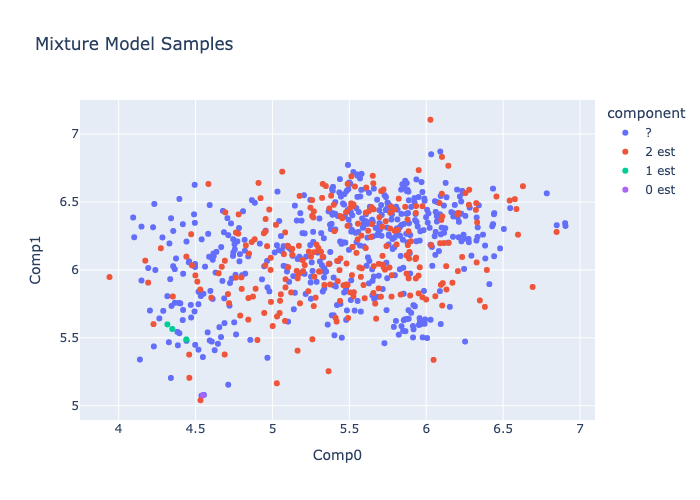

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 305.60it/s]

K = 3,   Q = -334.153683649668,   loglike = 5.503892091431824

mus_0 = [4.49703584 5.81549456],
  sigmas_0 = [[ 0.03544755 -0.00960695]
 [-0.00960695  0.11647729]],
  pis_0 = 0.17490150616745137

mus_1 = [5.35343017 5.91109961],
  sigmas_1 = [[ 0.21081321 -0.09161829]
 [-0.09161829  0.0625982 ]],
  pis_1 = 0.2992702437771336

mus_2 = [5.80610566 6.37521033],
  sigmas_2 = [[ 0.13485547 -0.00589341]
 [-0.00589341  0.02890377]],
  pis_2 = 0.525828250055415




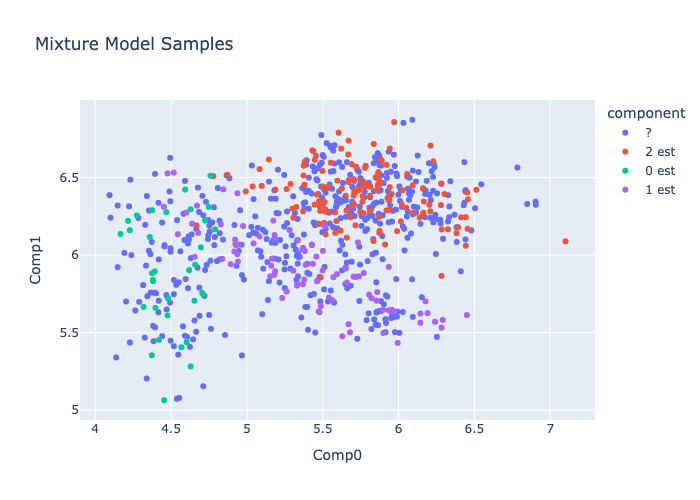

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 305.42it/s]

K = 3,   Q = -78.18241799572365,   loglike = 9.984504641101095

mus_0 = [5.91647855 5.60462759],
  sigmas_0 = [[0.00544101 0.0002359 ]
 [0.0002359  0.00369096]],
  pis_0 = 0.058923504885476444

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.004210525737131999

mus_2 = [5.41583555 6.17676476],
  sigmas_2 = [[0.37447711 0.09006759]
 [0.09006759 0.10071915]],
  pis_2 = 0.9368659693773916




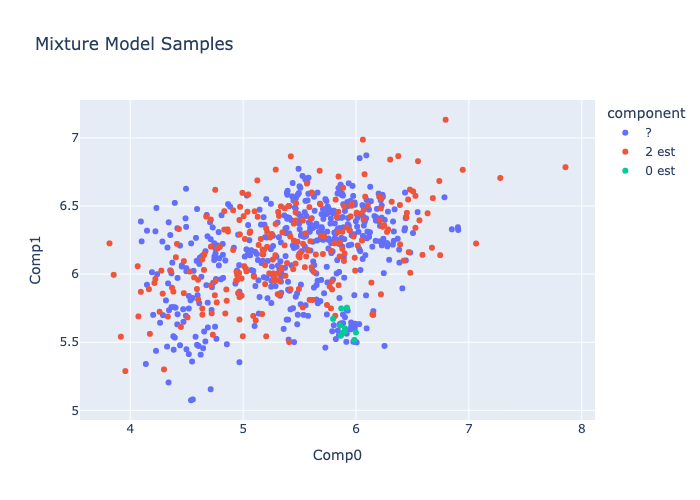

In [20]:
for sd in range(10):
    np.random.seed(sd)
    
    mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 3)
    print(mixMod)

    xs_, ids_ = mixMod.sample(256)

    df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
    df3 =  pd.concat([df, df2], axis=0)

    fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
    fig.show(renderer='png')

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 231.48it/s]

K = 4,   Q = -349.6548565731305,   loglike = 9.986163753492107

mus_0 = [5.91775584 5.60638645],
  sigmas_0 = [[ 5.04733592e-03 -5.80968278e-06]
 [-5.80968278e-06  3.56334424e-03]],
  pis_0 = 0.057550681109844674

mus_1 = [5.86319067 6.39752168],
  sigmas_1 = [[ 0.11542607 -0.00919119]
 [-0.00919119  0.02335543]],
  pis_1 = 0.3971385940641498

mus_2 = [5.08863516 6.01310235],
  sigmas_2 = [[0.31026969 0.03594057]
 [0.03594057 0.09575836]],
  pis_2 = 0.5411001998801696

mus_3 = [4.54655825 5.07672211],
  sigmas_3 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_3 = 0.004210524945835976




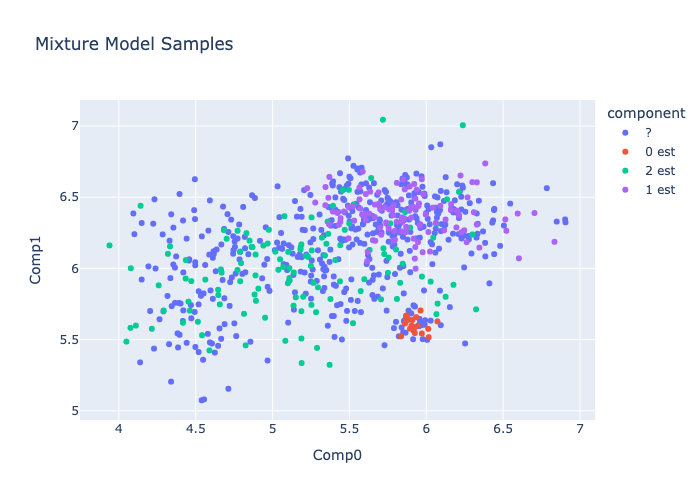

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 240.32it/s]

K = 4,   Q = -311.6799351384786,   loglike = 9.985718662667864

mus_0 = [5.35982928 5.90954993],
  sigmas_0 = [[ 0.20754019 -0.09097059]
 [-0.09097059  0.06265333]],
  pis_0 = 0.2967092915337464

mus_1 = [5.80654039 6.37527428],
  sigmas_1 = [[ 0.13462572 -0.00593536]
 [-0.00593536  0.02890235]],
  pis_1 = 0.5255035002220514

mus_2 = [4.49866431 5.83832841],
  sigmas_2 = [[ 0.03708259 -0.00834506]
 [-0.00834506  0.10549975]],
  pis_2 = 0.17357668981624771

mus_3 = [4.54655825 5.07672211],
  sigmas_3 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_3 = 0.004210518427954472




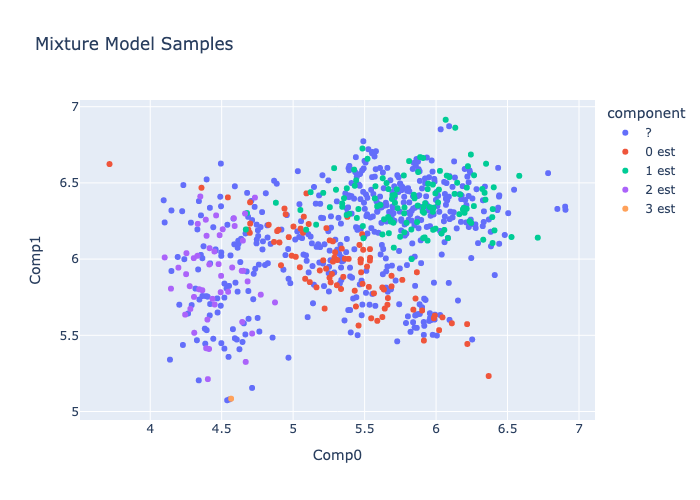

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 239.66it/s]


K = 4,   Q = -211.75802776655354,   loglike = 9.98431743546626

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.004210522307027925

mus_1 = [5.69990195 6.20327724],
  sigmas_1 = [[0.16002336 0.01670863]
 [0.01670863 0.09642518]],
  pis_1 = 0.7783819875909723

mus_2 = [4.38144792 5.54106419],
  sigmas_2 = [[ 0.0115048  -0.0102802 ]
 [-0.0102802   0.00922485]],
  pis_2 = 0.012827565826577455

mus_3 = [4.54407915 5.95096215],
  sigmas_3 = [[0.04501654 0.00037077]
 [0.00037077 0.1101287 ]],
  pis_3 = 0.2045799242754224




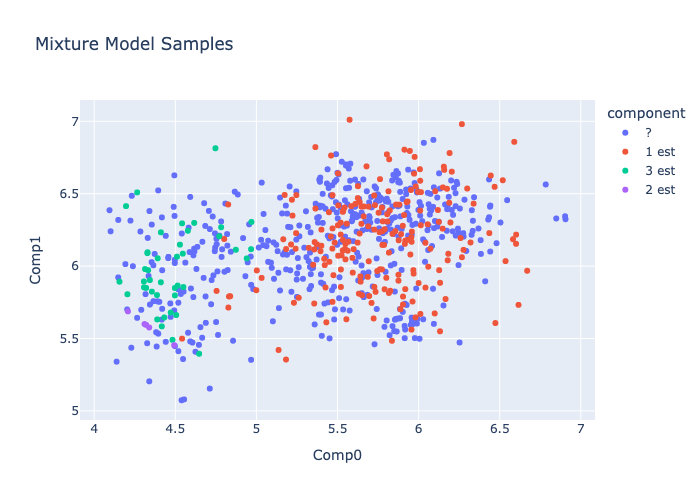

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.16it/s]

K = 4,   Q = -258.1287583613208,   loglike = 9.984038291217155

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.004210526027222467

mus_1 = [4.5468019  5.07681215],
  sigmas_1 = [[6.30130735e-05 2.32874210e-05]
 [2.32874210e-05 8.60623643e-06]],
  pis_1 = 2.6080727478354093e-13

mus_2 = [5.2381011  5.66480668],
  sigmas_2 = [[0.40636    0.02048241]
 [0.02048241 0.03038356]],
  pis_2 = 0.23685837668210982

mus_3 = [5.51017552 6.29212336],
  sigmas_3 = [[0.33657565 0.04329002]
 [0.04329002 0.04544405]],
  pis_3 = 0.7589310972904069




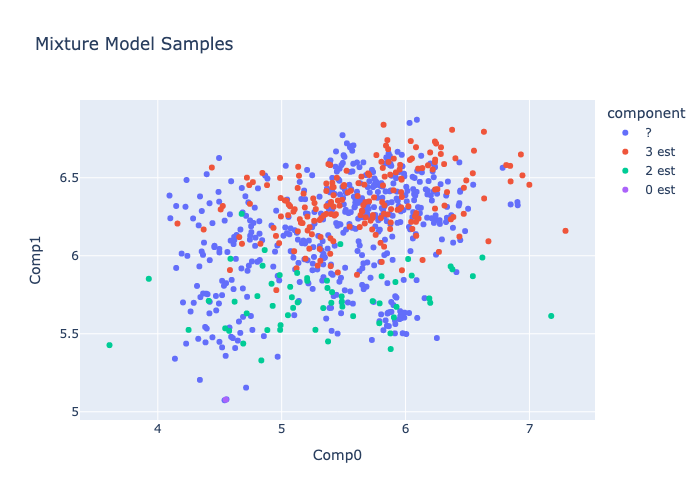

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 238.21it/s]

K = 4,   Q = -59.7107261150319,   loglike = 9.98603628433144

mus_0 = [4.52153557 5.40637344],
  sigmas_0 = [[ 0.00042423 -0.00076036]
 [-0.00076036  0.00136429]],
  pis_0 = 0.006297163548462409

mus_1 = [4.54655825 5.07672211],
  sigmas_1 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_1 = 0.004210525336093886

mus_2 = [5.4579935  6.15160397],
  sigmas_2 = [[0.35876786 0.06109335]
 [0.06109335 0.10859822]],
  pis_2 = 0.9832332088506556

mus_3 = [4.40612213 5.51818314],
  sigmas_3 = [[ 0.00064401 -0.00073944]
 [-0.00073944  0.00085343]],
  pis_3 = 0.006259102264788053




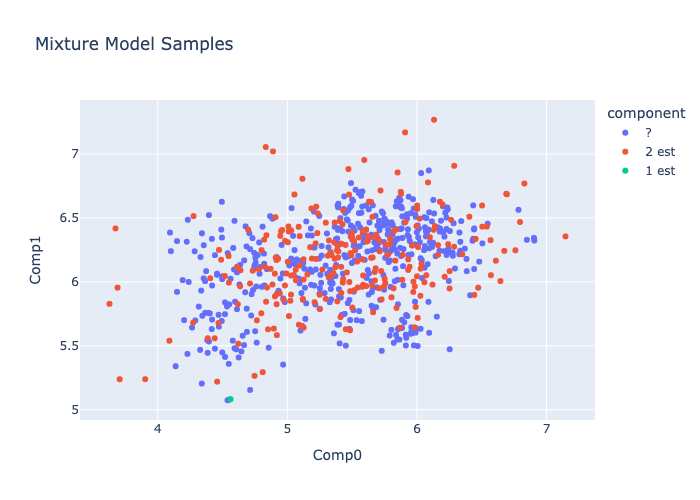

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 243.55it/s]

K = 4,   Q = -211.75803444331603,   loglike = 9.984317435437525

mus_0 = [4.38144793 5.54106419],
  sigmas_0 = [[ 0.0115048  -0.0102802 ]
 [-0.0102802   0.00922485]],
  pis_0 = 0.012827565939584127

mus_1 = [4.54407917 5.95096216],
  sigmas_1 = [[0.04501655 0.00037077]
 [0.00037077 0.1101287 ]],
  pis_1 = 0.2045799377480031

mus_2 = [4.54655825 5.07672211],
  sigmas_2 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_2 = 0.004210522307028547

mus_3 = [5.69990197 6.20327724],
  sigmas_3 = [[0.16002335 0.01670863]
 [0.01670863 0.09642518]],
  pis_3 = 0.7783819740053841




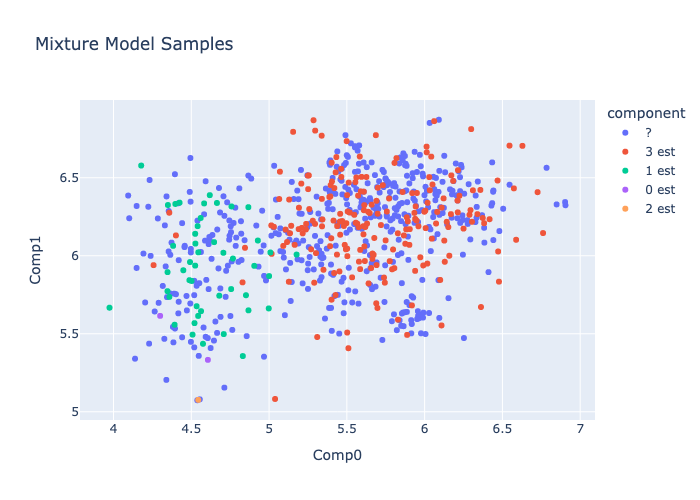

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.89it/s]

K = 4,   Q = -236.71326920140882,   loglike = 9.983986716459933

mus_0 = [4.54655825 5.07672211],
  sigmas_0 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_0 = 0.004210522559641226

mus_1 = [4.55316646 5.94842802],
  sigmas_1 = [[0.0420374  0.0103315 ]
 [0.0103315  0.10898106]],
  pis_1 = 0.1941045526760699

mus_2 = [4.37991533 5.78800634],
  sigmas_2 = [[ 0.03435475 -0.06322   ]
 [-0.06322     0.1297691 ]],
  pis_2 = 0.023662711598501557

mus_3 = [5.70048079 6.20222412],
  sigmas_3 = [[0.15946673 0.01748743]
 [0.01748743 0.09696487]],
  pis_3 = 0.7780222131657872




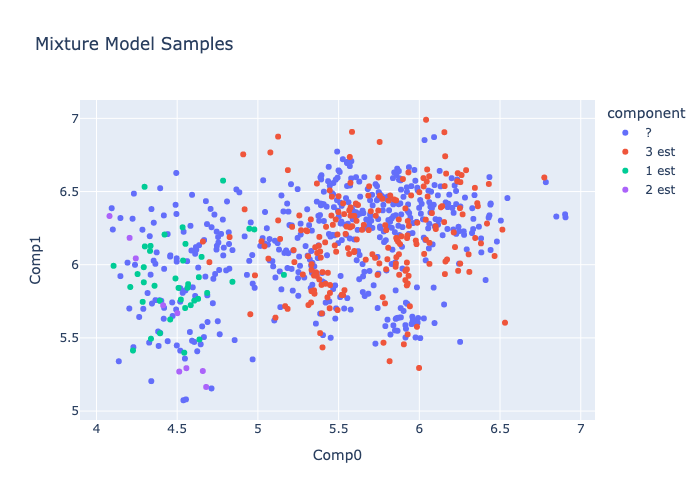

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.74it/s]

K = 4,   Q = -211.75803458085903,   loglike = 9.984317435448359

mus_0 = [4.38144793 5.54106419],
  sigmas_0 = [[ 0.0115048  -0.0102802 ]
 [-0.0102802   0.00922485]],
  pis_0 = 0.012827565941910164

mus_1 = [5.69990197 6.20327724],
  sigmas_1 = [[0.16002335 0.01670863]
 [0.01670863 0.09642518]],
  pis_1 = 0.7783819737257683

mus_2 = [4.54655825 5.07672211],
  sigmas_2 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_2 = 0.00421052230702856

mus_3 = [4.54407917 5.95096216],
  sigmas_3 = [[0.04501655 0.00037077]
 [0.00037077 0.1101287 ]],
  pis_3 = 0.2045799380252929




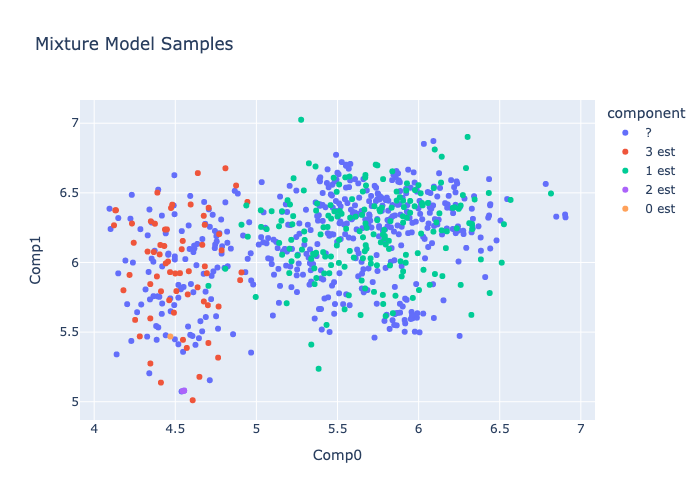

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 239.13it/s]

K = 4,   Q = -341.1503939018216,   loglike = 5.580388701465561

mus_0 = [4.48881173 5.76686084],
  sigmas_0 = [[ 0.0332022  -0.01182074]
 [-0.01182074  0.10620845]],
  pis_0 = 0.15429030920219133

mus_1 = [5.19386395 6.00165935],
  sigmas_1 = [[ 0.19481141 -0.06947117]
 [-0.06947117  0.05438751]],
  pis_1 = 0.2828094209107814

mus_2 = [5.81829579 6.37998043],
  sigmas_2 = [[ 0.12972968 -0.0071205 ]
 [-0.0071205   0.02820174]],
  pis_2 = 0.5113842648031293

mus_3 = [5.91731355 5.60413255],
  sigmas_3 = [[4.53210181e-03 7.70865702e-05]
 [7.70865702e-05 3.19234095e-03]],
  pis_3 = 0.05151600508389798




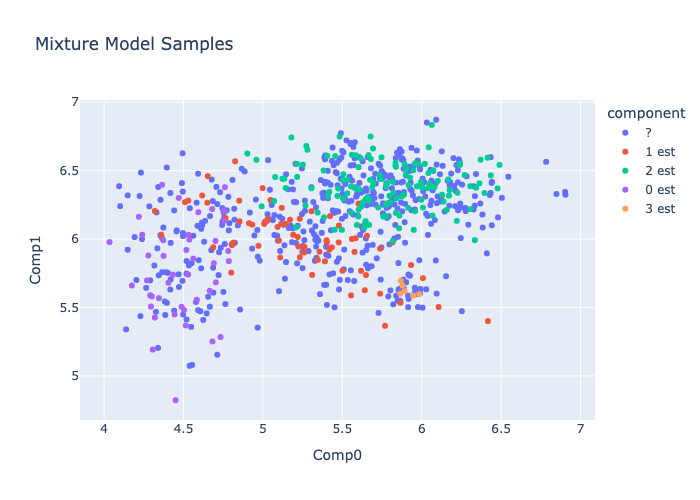

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 240.20it/s]

K = 4,   Q = -212.97187100375226,   loglike = 9.984117374133394

mus_0 = [4.3873893 5.5064058],
  sigmas_0 = [[3.04939483e-05 5.08300500e-05]
 [5.08300500e-05 2.00406154e-03]],
  pis_0 = 0.005623228910320877

mus_1 = [4.53701401 5.93722949],
  sigmas_1 = [[0.04465272 0.00165327]
 [0.00165327 0.11174028]],
  pis_1 = 0.21097467445255616

mus_2 = [4.54655825 5.07672211],
  sigmas_2 = [[6.30724370e-05 2.33093597e-05]
 [2.33093597e-05 8.61434420e-06]],
  pis_2 = 0.00421052152418767

mus_3 = [5.69906746 6.20319359],
  sigmas_3 = [[0.16056038 0.016744  ]
 [0.016744   0.09638697]],
  pis_3 = 0.7791915751129352




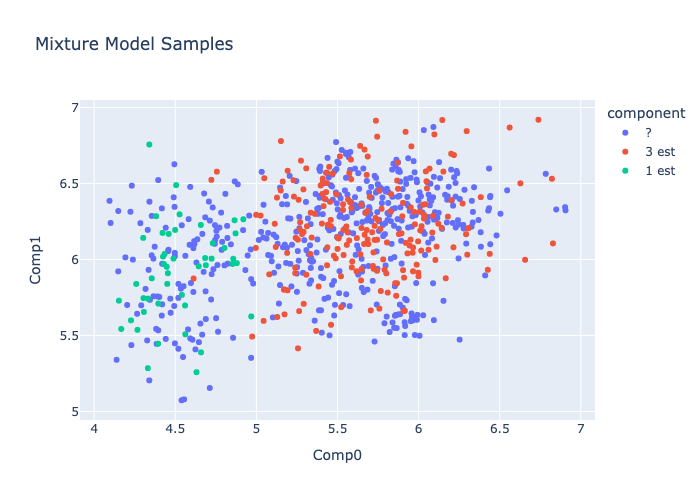

In [21]:
for sd in range(10):
    np.random.seed(sd)
    
    mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 4)
    print(mixMod)

    xs_, ids_ = mixMod.sample(256)

    df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
    df3 =  pd.concat([df, df2], axis=0)

    fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
    fig.show(renderer='png')

Были какие-то странные распределения которые давали большее правдоподобие, но это скорее всего уже идет переобучение модели - распределения со слишком маленькмими значениями $\pi$ мы отметаем. Я считаю что самыми правдоподобными являются эти две смеси и рабосих в мастерской соответственно занято два или три. 

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 485.95it/s]

K = 2,   Q = -235.9633416113735,   loglike = 5.33446851295143

mus_0 = [4.52787675 5.90595993],
  sigmas_0 = [[0.04153629 0.00182962]
 [0.00182962 0.12558471]],
  pis_0 = 0.2172132195999174

mus_1 = [5.69524231 6.20292553],
  sigmas_1 = [[0.16314398 0.01685344]
 [0.01685344 0.09608912]],
  pis_1 = 0.7827867804000826




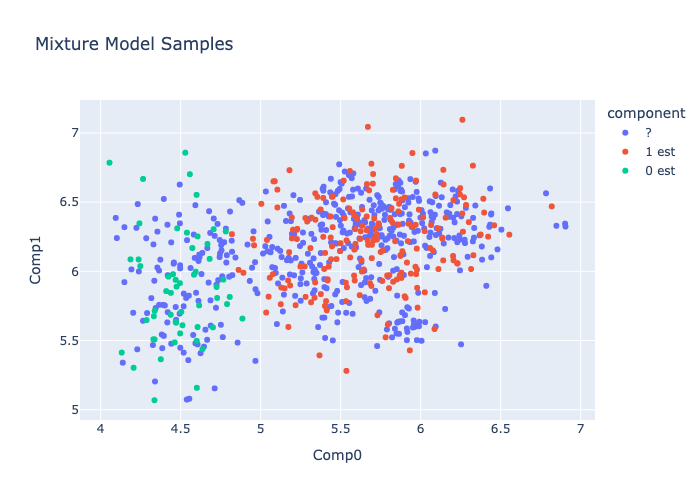

In [22]:
np.random.seed(6)

mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 2)
print(mixMod)

xs_, ids_ = mixMod.sample(256)

df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
df3 =  pd.concat([df, df2], axis=0)

fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.77it/s]

K = 3,   Q = -334.153683649668,   loglike = 5.503892091431824

mus_0 = [4.49703584 5.81549456],
  sigmas_0 = [[ 0.03544755 -0.00960695]
 [-0.00960695  0.11647729]],
  pis_0 = 0.17490150616745137

mus_1 = [5.35343017 5.91109961],
  sigmas_1 = [[ 0.21081321 -0.09161829]
 [-0.09161829  0.0625982 ]],
  pis_1 = 0.2992702437771336

mus_2 = [5.80610566 6.37521033],
  sigmas_2 = [[ 0.13485547 -0.00589341]
 [-0.00589341  0.02890377]],
  pis_2 = 0.525828250055415




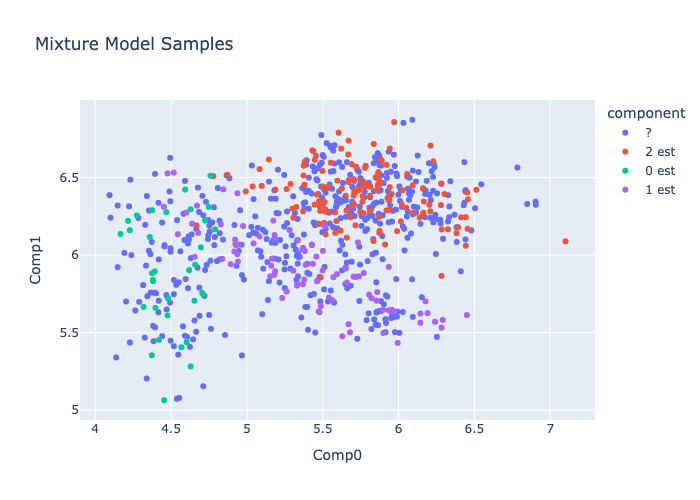

In [23]:
np.random.seed(8)

mixMod.fit(df[['Comp0', 'Comp1']].to_numpy(), 100, 3)
print(mixMod)

xs_, ids_ = mixMod.sample(256)

df2 = pd.DataFrame({"Comp0" : xs_[:, 0], "Comp1" : xs_[:, 1], 'component' : pd.Series(ids_.astype(str)).apply(lambda x: x + " est")})
df3 =  pd.concat([df, df2], axis=0)

fig = px.scatter(df3, x='Comp0', y='Comp1', color='component', title='Mixture Model Samples')
fig.show(renderer='png')

## Задача 2. Тотальный контроль (5 баллов)

В чат по теории вероятности сообщения приходят круглосуточно и особенно часто -- в кризисное время, когда у всех проходят коллоквиумы и разные другие контрольные мероприятия. Если выгрузить сырой лог из чата, то можно посчитать длину сообщения в символах $X$ и момент времени $T$, когда сообщение пришло в чат. Предполагается, что $X$ и $T$ независимы, а также промежутки времени $\Delta T_i = T_{i+1} - T_i$ являются независимыми в совокупности.

Исследуя интернет, вы наткнулись на подходящее [экспоненциальное распределение](https://en.wikipedia.org/wiki/Exponential_distribution), которое используется в survival analysis, исследовании времён до происхождения следующего события, которое можно использовать для моделирования времени, и на уже известное [логнормальное распределение](https://en.wikipedia.org/wiki/Log-normal_distribution) для моделирования длины сообщений (несмотря на то, что длины целые, мы попробуем).

На основе наблюдений предложите вероятностную модель на основе смесей распределений, которая помогла бы вам научиться определять, является ли конкретный момент времени $t$, когда было прислано сообщение длины $x$, кризисным.

Как и раньше, действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте гистограммы для $X_i$ и $\Delta T_i$ -- длин сообщений и времени, прошедшего с предыдущего сообщения.

In [ ]:
with open("./terver.pkl","rb") as f:
    dd = pkl.load(f)
    #??

In [ ]:
#your scatter plot and comments

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. 

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i, \Delta T_{i-1})$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

ВАШИ ОТВЕТЫ И КОММЕНТАРИИ ЗДЕСЬ

### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

ВАШИ ФОРМУЛЫ И КОММЕНТАРИИ ЗДЕСЬ

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [ ]:
class CustomMixtureModel:
    '''
    Implements Weibull Mixture Model in R^d
    '''

    def __init__(self,K,lambdas, pis, mus, sigmas):
        """
        Args:
            K (int, optional): number of components.
            mus (list, optional): K entries of (d,), expected values.
            sigmas (list, optional): K entries of (d,d,), covariances.
            pis (list, optional): K floats, weights, positive and sump up to 1.
        """        
        self.K=K
        self.pis = pis
        self.lambdas = lambdas
        self.mus = mus
        self.sigmas = sigmas

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print
        """ 
        return f"CustomMixture:\n pis={self.pis},\n mus={self.mus},\n sigmas={self.sigmas},\n lambdas={self.lambdas}"

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """        
        raise NotImplementedError
        #YOUR CODE
        #return result, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        raise NotImplementedError
        #YOUR CODE
    
    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """        
        raise NotImplementedError
        #YOUR CODE
        
        
    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """        
        for _ in tqdm.tqdm(np.arange(nSteps)):
            #YOUR CODE
            break
        pass
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): given data (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        #self.gammas
        raise NotImplementedError
        #YOUR CODE
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): given data (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        #self.gammas
        raise NotImplementedError
        #YOUR CODE


In [ ]:
#Test1: init model and sample from it, draw scatter plot

In [ ]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.

### Ответы

Какие сообщения были написаны в кризисное время, а какие в нормальное?

Какая доля сообщений была написана в кризисное время?

Обоснуйте свои ответы, используя ваш код.

ВАШИ КОМЕНТАРИИ И КОД ЗДЕСЬ